In this exercise we will use a recurrent neural network to forecast electricity prices in spain, using information such as actual and projected energy production. I have prepared data loading for you, your task is to implement a recurrent network architecture (I recommend an encoder-decoder setup) and train it.

In the settings below, you will be forecasting the electricity price for the coming 24 hrs using prices and generation information from the previous 48 hrs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nicholasjhana/energy-consumption-generation-prices-and-weather")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'energy-consumption-generation-prices-and-weather' dataset.
Path to dataset files: /kaggle/input/energy-consumption-generation-prices-and-weather


In [ ]:

#energy_data=pd.read_csv('/root/.cache/kagglehub/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/versions/1/energy_dataset.csv')
energy_data=pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')

# extract columns 'time' and 'price actual', and remove from table:
time=energy_data['time']
price=energy_data['price actual']
energy_data.drop(columns=['time','price actual'],inplace=True)
#print(energy_data)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
energy_data=scaler.fit_transform(energy_data)


def split_data(data,train_ratio=0.8):
    train_size=int(len(data)*train_ratio)
    train_data=data[:train_size]
    test_data=data[train_size:]
    return np.asarray(train_data),np.asarray(test_data)

train_X,test_X=split_data(energy_data)
train_Y,test_Y=split_data(price)

train_X,val_X=split_data(train_X)
train_Y,val_Y=split_data(train_Y)

#to tensors:
train_X=torch.tensor(train_X,dtype=torch.float32)
train_Y=torch.tensor(train_Y,dtype=torch.float32)
val_X=torch.tensor(val_X,dtype=torch.float32)
val_Y=torch.tensor(val_Y,dtype=torch.float32)
test_X=torch.tensor(test_X,dtype=torch.float32)
test_Y=torch.tensor(test_Y,dtype=torch.float32)

class energyDataset(torch.utils.data.Dataset):
    def __init__(self,X,Y,L=1,output_size=24):
        self.X=X
        self.Y=Y
        self.L=L
        self.output_size=output_size

        #make nan values 0:
        self.X[torch.isnan(self.X)]=0
        self.Y[torch.isnan(self.Y)]=0

    def __len__(self):
        return len(self.Y)-self.L-self.output_size+1

    def __getitem__(self,idx):
        Ytarget=self.Y[idx+self.L:idx+self.L+self.output_size].clone()
        Yfeature=self.Y[idx:idx+self.L].clone()
        Yfeature[-1]=0

        X=self.X[idx:idx+self.L,:]
        X=torch.cat((X,Yfeature.reshape(-1,1)),dim=1)

        return X,Ytarget

#unit tests:
ds=energyDataset(test_X,test_Y,L=48,output_size=24)
X,y=ds[0]

print(X.shape)
print(y.shape)

#print(test_X.shape)
#test_X[0:48,:].shape

torch.Size([48, 28])
torch.Size([24])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In the above, we set up a simple data split, training on the first 80% of the data and testing on the last 20%. We also set up a data set class, and add previous electricity prices as features to the model.

Below, you have to define a model that takes in 48 hrs of data and outputs a prediction of the next 24 hrs of electricity prices.

In [ ]:

class simpleModel(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1,output_size=24):
        super(simpleModel,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.gru=nn.GRU(input_size,hidden_size,num_layers,batch_first=True,bidirectional=False)
        self.fc=nn.Linear(hidden_size,output_size)
        self.h0=nn.Parameter(torch.zeros(self.num_layers,self.hidden_size),requires_grad=True)

    def forward(self,input):
        '''input: tuple (x,h0)
        x: input tensor of shape (batch_size,seq_len,input_size)'''

        x,h0=input

        assert x.shape[2]==self.input_size
        if h0 is None:
            h0=self.h0.unsqueeze(1).expand(-1,x.shape[0],-1).contiguous() #expands to shape (num_layers,batch_size,hidden_size)

        assert h0.shape[0] is self.num_layers
        assert h0.shape[2] is self.hidden_size

        #print(x.shape)
        out,h1=self.gru(x,h0)
        #print(out.shape)
        inter = out[:,-1,:]
        #print(inter.shape)
        out=self.fc(inter)
        #print(out.shape)
        #print(h1)


        return out,h1

#unit tests:
net=simpleModel(24,128)
out,h1 = net((torch.randn(256,24,24),None))

torch.Size([256, 24, 24])
torch.Size([256, 24, 128])
torch.Size([256, 128])
torch.Size([256, 24])


And now we train the model ('simpleModel' refers to my own model):

In [ ]:

nbatch=1024
hidden_size=128
input_size=train_X.shape[1]+1
L=48
target_size=24
patience = 5

#set up dataloaders:
ds_train=energyDataset(train_X,train_Y,L=L,output_size=target_size)
ds_val=energyDataset(val_X,val_Y,L=L,output_size=target_size)
ds_test=energyDataset(test_X,test_Y,L=L,output_size=target_size)

dl_train=torch.utils.data.DataLoader(ds_train,batch_size=nbatch,shuffle=True)
dl_val=torch.utils.data.DataLoader(ds_val,batch_size=nbatch,shuffle=False)
dl_test=torch.utils.data.DataLoader(ds_test,batch_size=nbatch,shuffle=False)

net=simpleModel(input_size,hidden_size,output_size=target_size).to(device)

loss_fn=nn.MSELoss(reduction='sum')
optimizer=torch.optim.Adam(net.parameters(),lr=0.005,weight_decay=1e-5)

nEpochs=100
bestValLoss = torch.inf
counter = 0

for iEpoch in range(nEpochs):
    net.train()
    totTrainLoss=0

    for i,(X,Y) in enumerate(dl_train):
        X,Y=X.to(device),Y.to(device)
        optimizer.zero_grad()
        Y_pred,_=net((X,None))
        loss=loss_fn(Y_pred,Y)
        loss.backward()
        optimizer.step()

        totTrainLoss+=loss.item()


    net.eval()
    totValLoss=0
    with torch.no_grad():
        for i,(X,Y) in enumerate(dl_val):
            X,Y=X.to(device),Y.to(device)
            Y_pred,_=net((X,None))
            loss=loss_fn(Y_pred,Y)

            totValLoss+=loss.item()

    if totValLoss < bestValLoss:
        counter = 0
        bestValLoss = totValLoss
    else:
        counter += 1
        if counter > patience:
            print("Early stopping due to no validation improvement")
            break

    print(f'Epoch {iEpoch+1}/{nEpochs}: train loss={totTrainLoss/len(ds_train):.4f}, val loss={totValLoss/len(ds_test):.4f}')


Epoch 1/100: train loss=63512.9281, val loss=43204.6286
Epoch 2/100: train loss=35182.5275, val loss=23080.0553
Epoch 3/100: train loss=18176.0857, val loss=11967.6365
Epoch 4/100: train loss=9936.2336, val loss=6661.3530
Epoch 5/100: train loss=6630.9287, val loss=4384.6832
Epoch 6/100: train loss=5407.0712, val loss=3465.9155
Epoch 7/100: train loss=4389.4005, val loss=2869.2977
Epoch 8/100: train loss=3765.4225, val loss=2526.4459
Epoch 9/100: train loss=3237.5349, val loss=2262.2783
Epoch 10/100: train loss=2857.2994, val loss=2107.0721
Epoch 11/100: train loss=2668.8218, val loss=1997.6366
Epoch 12/100: train loss=2554.0278, val loss=1955.6186
Epoch 13/100: train loss=2471.3938, val loss=1930.6014
Epoch 14/100: train loss=2414.0936, val loss=1862.7990
Epoch 15/100: train loss=2367.6913, val loss=1886.2171
Epoch 16/100: train loss=2334.2115, val loss=1828.4638
Epoch 17/100: train loss=2298.5646, val loss=1832.1115
Epoch 18/100: train loss=2278.9075, val loss=1804.0622
Epoch 19/100:

I have left in the output from my own training, but of course you are likely to get different values, since you will probably be using a different model.

In the next cell, I have tried plotting some randomly chosen sections of test data together with my model outputs. You should do the same with your model :)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([1, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


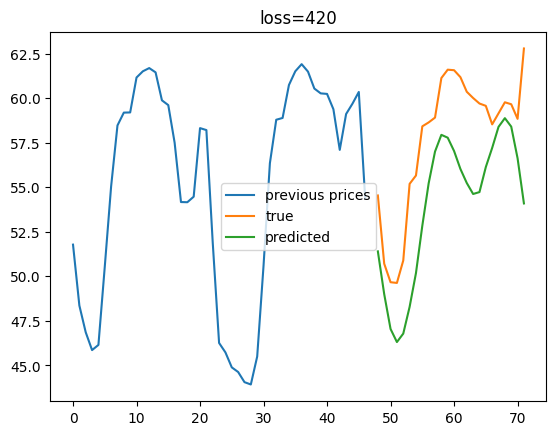

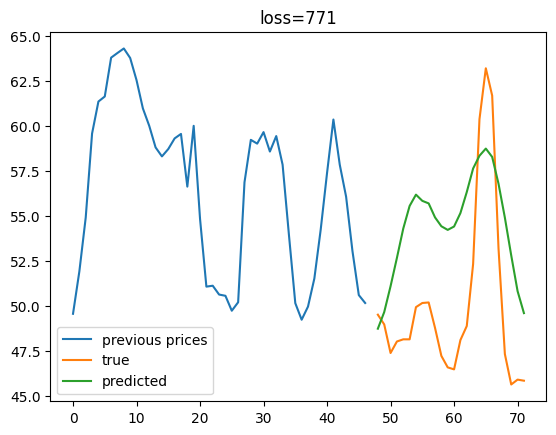

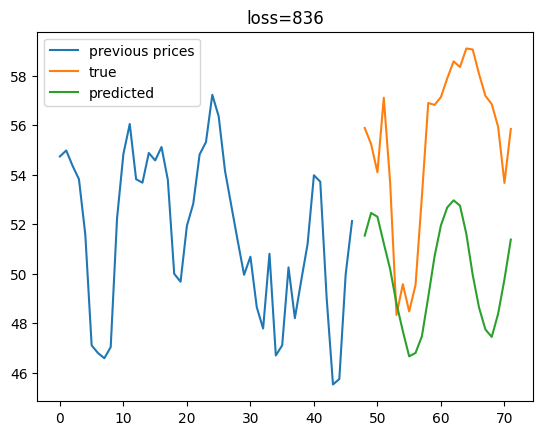

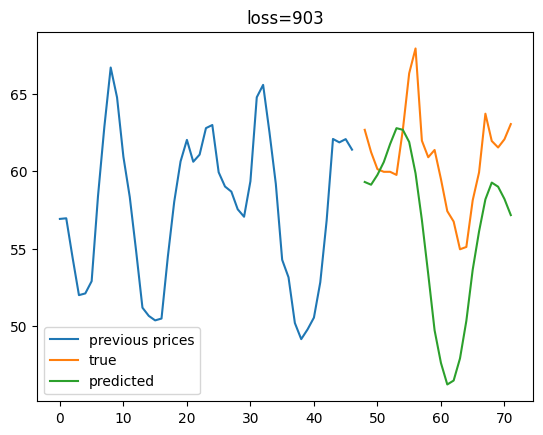

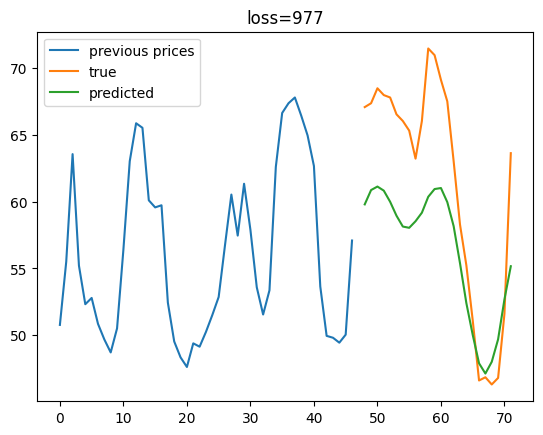

In [ ]:
#%% plot predictions

net.eval()
with torch.no_grad():
    for i in [0,100,500,1500,5000]:
        X,Y=ds_test[i]

        previousPrices=X[:,-1].numpy().copy()
        previousPrices[-1]=np.nan
        plt.plot(previousPrices,label='previous prices')

        X=X.to(device)
        X.unsqueeze_(0)
        Y_pred,_=net((X,None))

        loss=loss_fn(Y_pred.cpu(),Y)

        Y_pred=Y_pred.cpu().numpy()
        Y=Y.numpy()

        plt.title(f'loss={int(loss)}')

        plt.plot(np.arange(len(Y))+len(previousPrices),Y,label='true')
        plt.plot(np.arange(len(Y))+len(previousPrices),Y_pred.T,label='predicted')
        plt.legend()
        plt.show()

Here, finally, I was a little curious whether the model would loose its relevance over time (since the spanish energy market probably changes over time, so the model would be worse the further we get from the training data). That doesn't really seem to be the case though.

In [ ]:
#%% plot prediction quality as a function of time

net.eval()
hrs=[]
losses=[]
with torch.no_grad():
    for i in range(0,len(ds_test)):
        X,Y=ds_test[i]

        X=X.to(device)
        X.unsqueeze_(0)
        Y_pred,_=net((X,None))

        #loss:
        loss=loss_fn(Y_pred.cpu(),Y)

        hrs.append(i)
        losses.append(loss.item())



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([1, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Text(0, 0.5, 'loss')

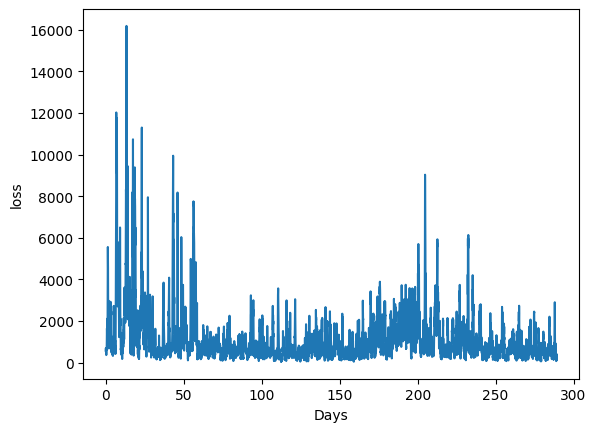

In [ ]:
plt.plot(np.array(hrs).astype(float)/24,losses)
plt.xlabel('Days')
plt.ylabel('loss')